# Data Visualization

In [ ]:
import pandas as pd
from pathlib import Path

xbd_path = 'datasets/xbd'
subsets = ('/train_bldgs/', '/hold_bldgs/', '/test_bldgs/', '/tier3_bldgs/')
disaster_folders = os.listdir(xbd_path + subsets[0])

i_subset = 0
i_disaster = 5

print(list(Path(xbd_path + subsets[i_subset] + disaster_folders[i_disaster]).glob('*.csv*'))[0])
labels = pd.read_csv(list(Path(xbd_path + subsets[i_subset] + disaster_folders[i_disaster]).glob('*.csv*'))[0])
labels.columns = ['name', 'xcoords', 'ycoords', 'long', 'lat', 'class']
zone = lambda row: '_'.join(row['name'].split('_', 2)[:2])
labels['zone'] = labels.apply(zone, axis=1)
labels['zone'].value_counts()
#labels['zone'].value_counts()[labels['zone'].value_counts()==1].index.tolist()

In [ ]:
from visualization import plot_on_image

plot_on_image(labels, subsets[i_subset], 'mexico-earthquake_00000192')

In [ ]:
from visualization import plot_on_map

plot_on_map(labels, mapbox=False)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from visualization import CmapString

cmap = CmapString(palette='viridis', domain=labels['zone'].values)

plt.figure(figsize=(12,8))
for _, row in labels.iterrows():
    plt.scatter(row['xcoords'], row['ycoords'], label=row['zone'], color=cmap.color(row['zone']))
plt.axis('off')
plt.show()

---

# Graph Generation

In [1]:
import os
from pathlib import Path
import json
import pandas as pd

path = 'datasets/xbd/train_bldgs/'
disaster_folders = os.listdir(path)
disaster = 'socal-fire'

labels = pd.read_csv(list(Path(path + disaster).glob('*.csv*'))[0], index_col=0)
labels.drop(columns=['long','lat'], inplace=True)
zone = lambda row: '_'.join(row.name.split('_', 2)[:2])
labels['zone'] = labels.apply(zone, axis=1)

processed_files = []
zones = labels['zone'].value_counts()[labels['zone'].value_counts()>1].index.tolist()
for zone in zones:
     if not ((labels[labels['zone'] == zone]['class'] == 'un-classified').all() or \
            (labels[labels['zone'] == zone]['class'] != 'un-classified').sum() == 1):
        processed_files.append(f'{zone}.pt')

len(processed_files)

346

In [2]:
for zone in [zones[0]]:
    if (labels[labels['zone'] == zone]['class'] == 'un-classified').all() or \
    (labels[labels['zone'] == zone]['class'] != 'un-classified').sum() == 1:
        continue
    print(f'Building {zone}...')
    list_pre_images = list(map(str, Path(path + disaster).glob(f'{zone}_pre_disaster*')))
    list_post_images = list(map(str, Path(path + disaster).glob(f'{zone}_post_disaster*')))
    coords = []

    for pre_image_file, post_image_file in zip(list_pre_images, list_post_images):
        
        annot = labels.loc[os.path.split(post_image_file)[1],'class']
        if annot == 'un-classified':
            continue
        coords.append((labels.loc[os.path.split(post_image_file)[1],'xcoord'],
                        labels.loc[os.path.split(post_image_file)[1],'ycoord']))

Building socal-fire_00000908...


---

# Graph Connectivity

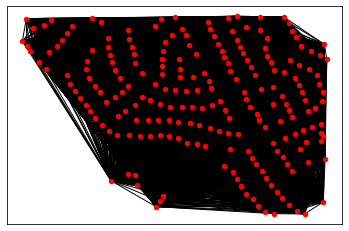

In [3]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx

data = torch.load('datasets/socal-fire_00000908.pt')
data.pos = torch.tensor(coords)
datax = to_networkx(data)
nx.draw_networkx(datax, pos=dict(enumerate(data.pos.numpy())), arrows=False,
                with_labels=False, node_size=20, node_color='red')

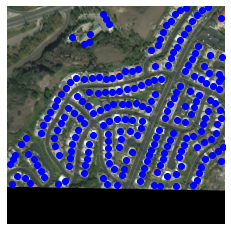

In [7]:
from visualization import plot_on_image
plot_on_image(labels, 'train', 'socal-fire_00000908')

In [4]:
data

Data(edge_attr=[23220, 2], edge_index=[2, 23220], pos=[216, 2], x=[216, 98304], y=[216])

In [4]:
data.edge_index

tensor([[  0,   0,   0,  ..., 213, 213, 214],
        [  1,   2,   3,  ..., 214, 215, 215]])

In [5]:
data.edge_attr

tensor([[0.8048, 0.0025],
        [0.7674, 0.0053],
        [0.7922, 0.0012],
        ...,
        [0.8144, 0.0058],
        [0.8400, 0.0012],
        [0.8449, 0.0014]])

In [5]:
from torch_geometric.transforms import Compose, Delaunay, FaceToEdge
trans = Compose([Delaunay(), FaceToEdge()])
datad = trans(data)
datad

Data(edge_attr=[23220, 2], edge_index=[2, 1264], pos=[216, 2], x=[216, 98304], y=[216])

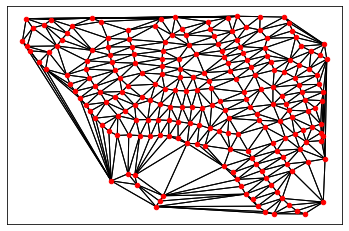

In [6]:
datadx = to_networkx(datad)
nx.draw_networkx(datadx, pos=dict(enumerate(data.pos.numpy())), arrows=False,
                with_labels=False, node_size=20, node_color='red')

---

# Training

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import RandomNodeSampler, GraphSAINTNodeSampler
from tqdm import tqdm
from dataset import xBD
from model import DeeperGCN
from metrics import score
from utils import get_class_weights

with open('exp_settings.json', 'r') as JSON:
    settings_dict = json.load(JSON)

seed = 42
batch_size = settings_dict['data']['batch_size']
num_steps = settings_dict['data']['saint_num_steps']
name = settings_dict['model']['name']
train_set = settings_dict['train_set']
if len(train_set) == 1:
    if train_set[0] == 'socal-fire':
        train_root = "/home/ami31/scratch/datasets/pixel/socal_train"
    else:
        train_root = "/home/ami31/scratch/datasets/pixel/sunda"
else:
    train_root = "/home/ami31/scratch/datasets/pixel/sunda_tucaloosa_puna"
test_root = "/home/ami31/scratch/datasets/pixel/socal_test"
hold_root = "/home/ami31/scratch/datasets/pixel/socal_hold"
hidden_units = settings_dict['model']['hidden_units']
num_layers = settings_dict['model']['num_layers']
dropout_rate = settings_dict['model']['dropout_rate']
lr = settings_dict['model']['lr']
n_epochs = settings_dict['epochs']
starting_epoch = settings_dict['starting_epoch']
path = settings_dict['model']['path']
save_best_only = settings_dict['save_best_only']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
train_dataset = xBD(train_root, 'train', train_set).shuffle()
test_dataset = xBD(test_root, 'test', train_set)
hold_dataset = xBD(hold_root, 'hold', ['socal-fire'])

In [ ]:
y_all = [data.y for data in train_dataset]
y_all = torch.cat(y_all)
torch.unique(y_all, return_counts=True)

In [ ]:
y_all = [data.y for data in test_dataset]
y_all = torch.cat(y_all)
torch.unique(y_all, return_counts=True)

In [ ]:
y_all = [data.y for data in hold_dataset]
y_all = torch.cat(y_all)
torch.unique(y_all, return_counts=True)

In [ ]:
model = DeeperGCN(hold_dataset.num_node_features,
                  hold_dataset.num_edge_features,
                  hidden_units,
                  hold_dataset.num_classes,
                  num_layers,
                  dropout_rate)
#model_path = path + '/' + name + '_best.pt'
#model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [ ]:
model.train()
class_weights = get_class_weights(train_set, train_dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
pbar = tqdm(total=len(train_dataset))
total_loss = 0
for data in train_dataset[:5]:
    if data.num_nodes > batch_size:
        sampler = GraphSAINTNodeSampler(data, batch_size=batch_size, num_steps=num_steps, num_workers=2)
        data_loss = 0
        total_examples = 0
        for subdata in sampler:
            subdata = subdata.to(device)
            optimizer.zero_grad()
            out = model(subdata.x, subdata.edge_index, subdata.edge_attr)
            loss = F.nll_loss(input=out, target=subdata.y, weight=class_weights.to(device))
            loss.backward()
            optimizer.step()
            data_loss += loss.item() * subdata.num_nodes
            total_examples += subdata.num_nodes
        total_loss += data_loss / total_examples
    else:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        loss = F.nll_loss(input=out, target=data.y, weight=class_weights.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    pbar.update()
pbar.close()
print(total_loss / len(train_dataset))

---